In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima

from xgboost import XGBRegressor
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

import keras_tuner as kt

from prophet import Prophet

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error


# Load & Inspect Data

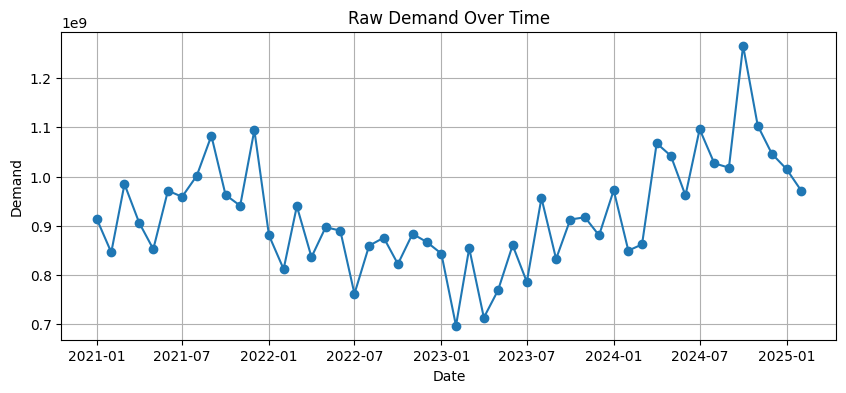

In [ ]:
df = pd.read_csv("data.csv")
df["period_start"] = pd.to_datetime(df["period_start"])

# Aggregate if multiple products/regions
df_grouped = df.groupby("period_start")["value"].sum().reset_index()
df_grouped.sort_values("period_start", inplace=True)
df_grouped = df_grouped.reset_index(drop=True)

plt.figure(figsize=(10,4))
plt.plot(df_grouped["period_start"], df_grouped["value"], marker='o')
plt.title("Raw Demand Over Time")
plt.xlabel("Date")
plt.ylabel("Demand")
plt.grid(True)
plt.show()


In [ ]:
# LOG TRANSFORM : log1p to reduce scale and variance.
df_grouped["value_log"] = np.log1p(df_grouped["value"])  # log(1 + x)

# 4) TRAIN/TEST SPLIT (Last 6 months for test)
time_series_log = df_grouped.set_index("period_start")["value_log"]
train_log = time_series_log.iloc[:-6]
test_log = time_series_log.iloc[-6:]

# Keep also the original demand for final error metrics
time_series_orig = df_grouped.set_index("period_start")["value"]
train_orig = time_series_orig.iloc[:-6]
test_orig = time_series_orig.iloc[-6:]

print("Train range:", train_log.index.min(), "to", train_log.index.max())
print("Test range :", test_log.index.min(), "to", test_log.index.max())


Train range: 2021-01-01 00:00:00 to 2024-08-01 00:00:00
Test range : 2024-09-01 00:00:00 to 2025-02-01 00:00:00


In [ ]:
# Helper function to evaluate performance
def evaluate_forecast(true_vals, pred_vals, model_name="Model"):
    """
    Computes RMSE, MAE, MAPE. 
    `true_vals` and `pred_vals` must be on the same original scale (not log).
    """
    rmse = np.sqrt(mean_squared_error(true_vals, pred_vals))
    mae = mean_absolute_error(true_vals, pred_vals)
    # Avoid dividing by zero in MAPE if there's a zero
    mask = true_vals != 0
    if mask.sum() == 0:
        mape = np.nan
    else:
        mape = np.mean(np.abs((true_vals[mask] - pred_vals[mask]) / true_vals[mask])) * 100
    print(f"{model_name} Performance on Last 6 Months:")
    print(f"  RMSE = {rmse:,.2f}")
    print(f"  MAE  = {mae:,.2f}")
    print(f"  MAPE = {mape:,.2f}%\n")
    return rmse, mae, mape

# SARIMA (Univariate) Forecast

In [ ]:
# Use auto_arima on train_log
auto_model = auto_arima(
    train_log,
    seasonal=True,
    m=12,
    d=None,
    D=1,
    trace=False,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True
)
print("Best ARIMA order:", auto_model.order)
print("Best Seasonal order:", auto_model.seasonal_order)

sarima_model = SARIMAX(
    train_log,
    order=auto_model.order,
    seasonal_order=auto_model.seasonal_order,
    enforce_stationarity=False,
    enforce_invertibility=False
).fit(disp=False)

# Forecast last 6 months (log scale)
sarima_pred_test_log = sarima_model.forecast(steps=6)
# Convert back to original scale
sarima_pred_test = np.expm1(sarima_pred_test_log)  # inverse of log1p => exp(x) - 1

# Evaluate
sarima_rmse, sarima_mae, sarima_mape = evaluate_forecast(test_orig.values, sarima_pred_test.values, "SARIMA")

# Forecast next 36 months
sarima_forecast_36_log = sarima_model.forecast(steps=36)
sarima_forecast_36 = np.expm1(sarima_forecast_36_log)
sarima_dates_36 = pd.date_range(start=train_log.index.max(), periods=36+1, freq='M')[1:]


c:\Users\SPMCIL S S BALANI\Documents\B&D\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\SPMCIL S S BALANI\Documents\B&D\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\SPMCIL S S BALANI\Documents\B&D\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\SPMCIL S S BALANI\Documents\B&D\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\SPMCIL S S BALANI\Documents\B&D\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force

Best ARIMA order: (2, 1, 0)
Best Seasonal order: (1, 1, 0, 12)
SARIMA Performance on Last 6 Months:
  RMSE = 88,946,160.38
  MAE  = 74,753,966.01
  MAPE = 6.97%



c:\Users\SPMCIL S S BALANI\Documents\B&D\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\SPMCIL S S BALANI\Documents\B&D\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\SPMCIL S S BALANI\AppData\Local\Temp\ipykernel_26232\3455849317.py:38: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  sarima_dates_36 = pd.date_range(start=train_log.index.max(), periods=36+1, freq='M')[1:]


# XGBoost (Univariate with Lags)

In [ ]:
# We'll create lag features for univariate log data
df_xgb = df_grouped[["period_start","value_log"]].copy()
df_xgb.set_index("period_start", inplace=True)

# Create lags
max_lag = 12
for lag in range(1, max_lag+1):
    df_xgb[f'lag_{lag}'] = df_xgb['value_log'].shift(lag)
df_xgb.dropna(inplace=True)

# Separate train/test
xgb_train = df_xgb.iloc[:-6]
xgb_test = df_xgb.iloc[-6:]

X_train_xgb = xgb_train.drop(columns=["value_log"])
y_train_xgb = xgb_train["value_log"]
X_test_xgb = xgb_test.drop(columns=["value_log"])
y_test_xgb = xgb_test["value_log"]

# TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=3)
xgb_base = XGBRegressor(random_state=42)

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.05, 0.01, 0.1]
}

grid_search = GridSearchCV(
    estimator=xgb_base,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=tscv,
    verbose=1
)
grid_search.fit(X_train_xgb, y_train_xgb)
best_params = grid_search.best_params_
print("XGBoost Best Params:", best_params)

# best_xgb = XGBRegressor(**best_params, random_state=42)
best_xgb = XGBRegressor(n_estimators=200, max_depth=5, learning_rate=0.05, random_state=42)
best_xgb.fit(X_train_xgb, y_train_xgb)

# Predict last 6 months (log)
xgb_pred_test_log = best_xgb.predict(X_test_xgb)
# Convert back
xgb_pred_test = np.expm1(xgb_pred_test_log)

# Evaluate
xgb_rmse, xgb_mae, xgb_mape = evaluate_forecast(test_orig.values, xgb_pred_test, "XGBoost")

# Forecast 36 months with iterative approach
# We'll store the last known row as the starting point
xgb_forecast_36 = []
current_data = df_xgb.iloc[-1].drop('value_log').values  # the last row's lag features
current_values = df_xgb['value_log'].values  # to rebuild lags

for _ in range(36):
    pred_log = best_xgb.predict(current_data.reshape(1, -1))[0]
    xgb_forecast_36.append(np.expm1(pred_log))  # store in original scale
    
    # Update current_values
    current_values = np.append(current_values, pred_log)
    # Rebuild lags
    new_lag_feats = []
    for lag in range(1, max_lag+1):
        new_lag_feats.append(current_values[-lag-1])
    new_lag_feats = new_lag_feats[::-1]  # reorder to match lag_1..lag_12
    current_data = np.array(new_lag_feats)

xgb_dates_36 = pd.date_range(start=train_log.index.max(), periods=36+1, freq='M')[1:]


Fitting 3 folds for each of 27 candidates, totalling 81 fits
XGBoost Best Params: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}
XGBoost Performance on Last 6 Months:
  RMSE = 121,309,362.11
  MAE  = 92,827,864.00
  MAPE = 8.47%



C:\Users\SPMCIL S S BALANI\AppData\Local\Temp\ipykernel_26232\2284470808.py:75: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  xgb_dates_36 = pd.date_range(start=train_log.index.max(), periods=36+1, freq='M')[1:]


# LSTM (Univariate) Forecast

In [ ]:
df_lstm = df_grouped.copy()
df_lstm.set_index("period_start", inplace=True)

# We'll store the log in a column
df_lstm["scaled_log"] = df_lstm["value_log"].values

# Create sequences
def create_sequences(data, seq_length=12):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

sequence_length = 12
data_array = df_lstm["scaled_log"].values
X_all, y_all = create_sequences(data_array, sequence_length)

# We keep last 6 data points as test
train_size = len(df_lstm) - 6
X_train_lstm = X_all[: train_size - sequence_length]
y_train_lstm = y_all[: train_size - sequence_length]
X_test_lstm = X_all[train_size - sequence_length:]
y_test_lstm = y_all[train_size - sequence_length:]

# Reshape for LSTM
X_train_lstm = X_train_lstm.reshape((X_train_lstm.shape[0], X_train_lstm.shape[1], 1))
X_test_lstm = X_test_lstm.reshape((X_test_lstm.shape[0], X_test_lstm.shape[1], 1))

# We can create a validation split from the tail of X_train_lstm if we want
val_split = int(len(X_train_lstm)*0.8)
X_train_lstm_, X_val_lstm = X_train_lstm[:val_split], X_train_lstm[val_split:]
y_train_lstm_, y_val_lstm = y_train_lstm[:val_split], y_train_lstm[val_split:]

def build_lstm_model(hp):
    model = Sequential()
    # Tune #units in LSTM
    units = hp.Int('units', min_value=32, max_value=128, step=32)
    model.add(LSTM(units, activation='relu', return_sequences=True, input_shape=(sequence_length, 1)))
    model.add(Dropout(hp.Float('dropout1', 0.0, 0.5, step=0.1)))
    
    # Second LSTM layer
    units2 = hp.Int('units2', min_value=32, max_value=128, step=32)
    model.add(LSTM(units2, activation='relu'))
    model.add(Dropout(hp.Float('dropout2', 0.0, 0.5, step=0.1)))
    
    model.add(Dense(1))
    
    lr = hp.Choice('learning_rate', [1e-3, 5e-4, 1e-4])
    model.compile(optimizer=Adam(learning_rate=lr), loss='mse')
    return model

tuner = kt.RandomSearch(
    build_lstm_model,
    objective='val_loss',
    max_trials=5,  # Increase for deeper search
    executions_per_trial=1,
    directory='lstm_tuning',
    project_name='improved_lstm'
)

tuner.search(X_train_lstm_, y_train_lstm_, 
             epochs=15, 
             validation_data=(X_val_lstm, y_val_lstm),
             verbose=1)

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best LSTM hyperparams:", best_hps.values)

model_lstm = tuner.hypermodel.build(best_hps)
model_lstm.fit(X_train_lstm_, y_train_lstm_, 
               epochs=30, 
               validation_data=(X_val_lstm, y_val_lstm),
               verbose=1)

# Predict on test (log scale)
lstm_pred_test_log = model_lstm.predict(X_test_lstm)
# Convert back
lstm_pred_test = np.expm1(lstm_pred_test_log)
# Evaluate
y_test_lstm_orig = np.expm1(y_test_lstm)  # invert test set from log scale
lstm_rmse, lstm_mae, lstm_mape = evaluate_forecast(y_test_lstm_orig, lstm_pred_test.flatten(), "LSTM")

# Forecast 36 months
last_seq = data_array[-sequence_length:].reshape(1, sequence_length, 1)
lstm_forecast_36 = []
for _ in range(36):
    pred_log = model_lstm.predict(last_seq)[0,0]
    lstm_forecast_36.append(np.expm1(pred_log))
    # roll
    new_seq = np.roll(last_seq, -1, axis=1)
    new_seq[0, -1, 0] = pred_log
    last_seq = new_seq

lstm_dates_36 = pd.date_range(start=train_log.index.max(), periods=36+1, freq='M')[1:]


Reloading Tuner from lstm_tuning\improved_lstm\tuner0.json
Best LSTM hyperparams: {'units': 32, 'dropout1': 0.30000000000000004, 'units2': 32, 'dropout2': 0.2, 'learning_rate': 0.001}
Epoch 1/30


c:\Users\SPMCIL S S BALANI\Documents\B&D\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 438.8341 - val_loss: 418.4766
Epoch 2/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 407.6835 - val_loss: 390.0692
Epoch 3/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 379.0045 - val_loss: 363.8520
Epoch 4/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 350.7090 - val_loss: 337.7392
Epoch 5/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 346.4861 - val_loss: 309.9226
Epoch 6/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 323.0818 - val_loss: 280.3561
Epoch 7/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 280.1749 - val_loss: 249.8633
Epoch 8/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 272.4620 - val_loss: 218.1224
Epoch 9/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 220.5691 - val_loss: 185.0534
Epoch 10/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 219.7900 - val_loss: 150.8592
Epoch 11/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 180.2430 - val_loss: 115.5457
Epoch 12/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - lo

C:\Users\SPMCIL S S BALANI\AppData\Local\Temp\ipykernel_26232\755907.py:98: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  lstm_dates_36 = pd.date_range(start=train_log.index.max(), periods=36+1, freq='M')[1:]


# Prophet (Univariate)

In [ ]:
df_prophet = df_grouped[["period_start", "value_log"]].copy()
df_prophet.columns = ["ds","y"]  # Prophet expects ds, y
df_prophet.sort_values("ds", inplace=True)

# Train/test for Prophet
prophet_train = df_prophet.iloc[:-6]
prophet_test = df_prophet.iloc[-6:].copy()

'''model_prophet = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=False,
    seasonality_mode='multiplicative'
)
# Example: add monthly seasonality
model_prophet.add_seasonality(name='monthly', period=30.5, fourier_order=5)
model_prophet.fit(prophet_train)'''

model_prophet = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
model_prophet.fit(prophet_train)

# Forecast 6 months
future_test = model_prophet.make_future_dataframe(periods=6, freq='M')
prophet_forecast_test = model_prophet.predict(future_test)

prophet_test_pred_log = prophet_forecast_test[['ds','yhat']].iloc[-6:]
prophet_test_pred_log.set_index("ds", inplace=True)

# Evaluate on test
prophet_test['pred_log'] = prophet_test_pred_log['yhat'].values
prophet_test['pred'] = np.expm1(prophet_test['pred_log'])
prophet_test['y_orig'] = np.expm1(prophet_test['y'])  # invert actual
prophet_rmse, prophet_mae, prophet_mape = evaluate_forecast(
    prophet_test['y_orig'].values,
    prophet_test['pred'].values,
    "Prophet"
)

# Forecast next 36 months
future_36 = model_prophet.make_future_dataframe(periods=36, freq='M')
prophet_forecast_36 = model_prophet.predict(future_36)
prophet_36 = prophet_forecast_36[['ds','yhat','yhat_lower','yhat_upper']].iloc[-36:].copy()
prophet_36['yhat'] = np.expm1(prophet_36['yhat'])
prophet_36['yhat_lower'] = np.expm1(prophet_36['yhat_lower'])
prophet_36['yhat_upper'] = np.expm1(prophet_36['yhat_upper'])


02:30:42 - cmdstanpy - INFO - Chain [1] start processing
02:30:42 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\SPMCIL S S BALANI\Documents\B&D\.venv\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


Prophet Performance on Last 6 Months:
  RMSE = 161,607,507.04
  MAE  = 113,546,959.34
  MAPE = 10.92%



c:\Users\SPMCIL S S BALANI\Documents\B&D\.venv\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


# Comparison Plots

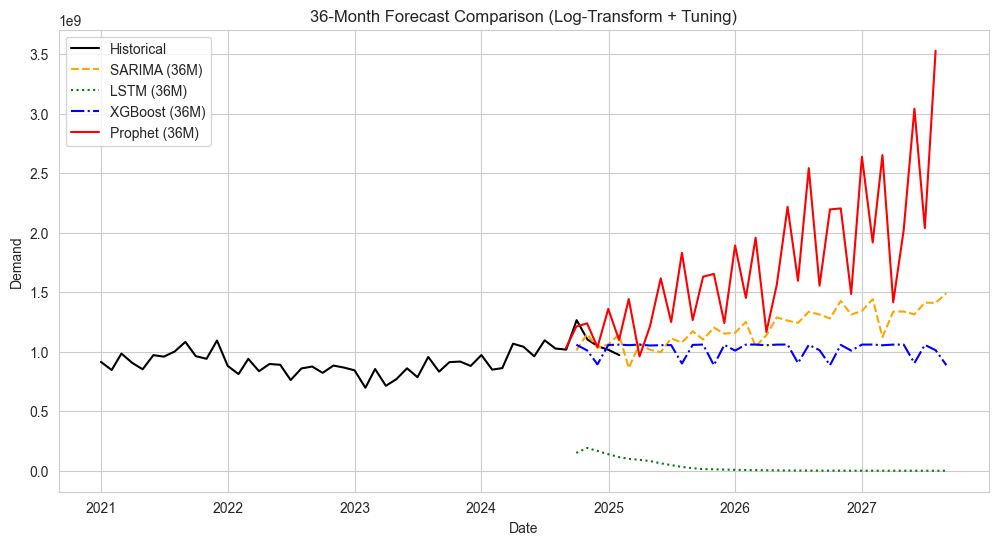

In [ ]:
sns.set_style('whitegrid')
plt.figure(figsize=(12,6))

# Plot historical
plt.plot(time_series_orig.index, time_series_orig.values, label='Historical', color='black')

# SARIMA
plt.plot(sarima_dates_36, sarima_forecast_36, label='SARIMA (36M)', linestyle='--', color='orange')

# LSTM
plt.plot(lstm_dates_36, lstm_forecast_36, label='LSTM (36M)', linestyle=':', color='green')

# XGBoost
plt.plot(xgb_dates_36, xgb_forecast_36, label='XGBoost (36M)', linestyle='-.', color='blue')

# Prophet
plt.plot(prophet_36['ds'], prophet_36['yhat'], label='Prophet (36M)', linestyle='-', color='red')

plt.title("36-Month Forecast Comparison (Log-Transform + Tuning)")
plt.xlabel("Date")
plt.ylabel("Demand")
plt.legend()
plt.show()


# Final Performance

In [ ]:
print("\n=== Final Performance on Last 6 Months ===")
print(f"SARIMA  => RMSE={sarima_rmse:.2f}, MAE={sarima_mae:.2f}, MAPE={sarima_mape:.2f}%")
print(f"LSTM    => RMSE={lstm_rmse:.2f}, MAE={lstm_mae:.2f}, MAPE={lstm_mape:.2f}%")
print(f"XGBoost => RMSE={xgb_rmse:.2f}, MAE={xgb_mae:.2f}, MAPE={xgb_mape:.2f}%")
print(f"Prophet => RMSE={prophet_rmse:.2f}, MAE={prophet_mae:.2f}, MAPE={prophet_mape:.2f}%")



=== Final Performance on Last 6 Months ===
SARIMA  => RMSE=88946160.38, MAE=74753966.01, MAPE=6.97%
LSTM    => RMSE=1072487546.35, MAE=1068180172.79, MAPE=99.84%
XGBoost => RMSE=121309362.11, MAE=92827864.00, MAPE=8.47%
Prophet => RMSE=161607507.04, MAE=113546959.34, MAPE=10.92%
